In [1]:
library(tidyverse)

── Attaching core tidyverse packages ───────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ─────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
con = DBI::dbConnect(RMariaDB::MariaDB(), groups='mariaDB')

In [3]:
coexpression_orf_list <- DBI::dbGetQuery(con, "select * from omer.coexpressionOrfList_blaste4")

In [7]:
expression = readRDS("/home/aar75/coexpression/20221110_rho/tpm_5_400.RDS")

In [8]:
gsea_slim <- data.table::fread('../data/interim/fgsea_slim_bp_noexponent.csv')

In [9]:
orfs_with_gsea <-coexpression_orf_list%>%filter(transcript%in%expression$transcript)%>%
inner_join(gsea_slim%>%filter(pathway!=''), by=c('transcript'))

# evolution

In [45]:
gsea_slim_counts_among_enriched_evo <-coexpression_orf_list%>%inner_join(gsea_slim%>%filter(pathway!='GO:0008150'), by=c('transcript'))%>%group_by(pathway,classification)%>%count()%>%
inner_join(coexpression_orf_list%>%filter(transcript%in%gsea_slim$transcript)%>%group_by(classification)%>%count(), by=c('classification'))%>%
mutate(prop = n.x/n.y, diff = n.y-n.x)%>%
filter(classification!='intergenic' & classification!='other')%>%
arrange(desc(prop))%>%left_join(
    AnnotationDbi::select(GO.db::GO.db, keys=gsea_slim$pathway%>%unique, columns = c('TERM')),
    by=c('pathway'='GOID')
)%>%pivot_wider(id_cols = c('pathway','TERM'),names_from='classification',values_from=c("n.x","diff",'prop'))%>%drop_na()%>%
    mutate(p_conserved_denovo = fisher.test(matrix(c(n.x_denovo,diff_denovo,n.x_conserved,diff_conserved),nrow=2))$p.value
          )%>%
mutate(odds = prop_denovo/prop_conserved)%>%arrange(desc(odds))

gsea_slim_counts_among_enriched_evo$fdr_conserved_denovo = p.adjust(gsea_slim_counts_among_enriched_evo$p_conserved_denovo, method='fdr')



'select()' returned 1:1 mapping between keys and columns



Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


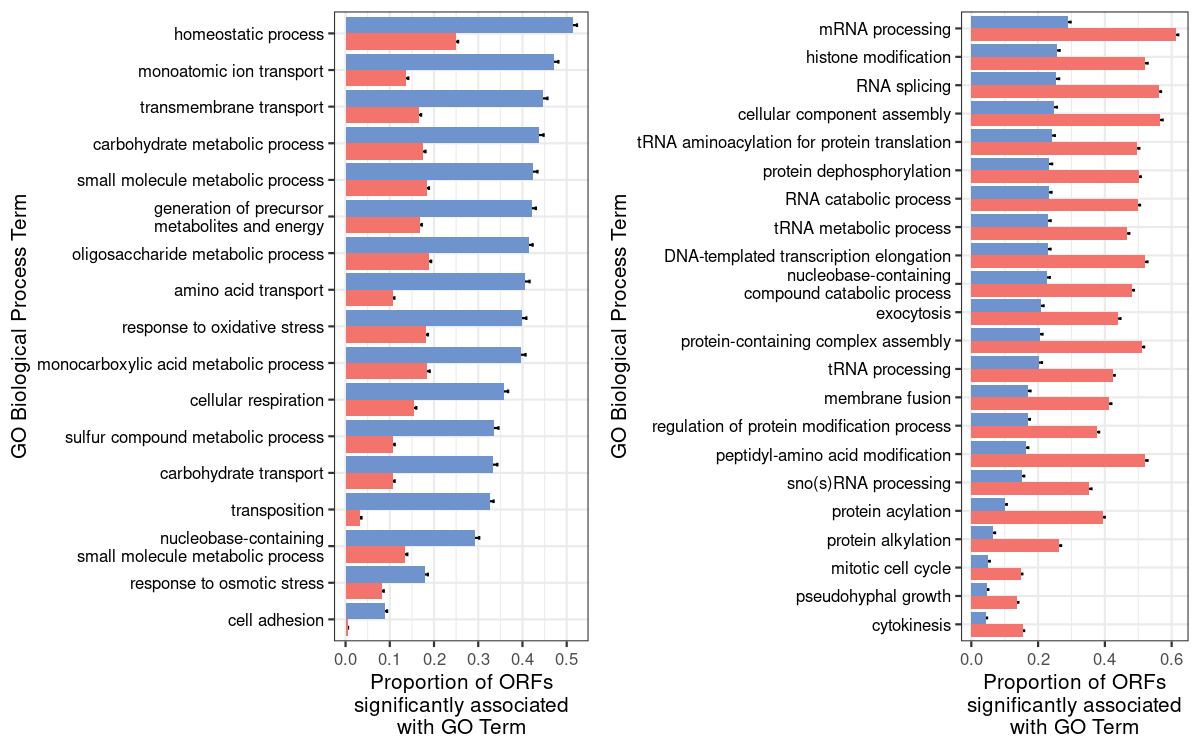

In [12]:
fig.size(8,5)

bar_plot_data = gsea_slim_counts_among_enriched_evo%>%filter(fdr_conserved_denovo<0.001)%>%filter(odds >2 | odds<0.5)%>%
mutate(or = ifelse(odds>1, 'enriched','purified'),
      TERM=case_when(
          TERM == 'generation of precursor metabolites and energy' ~ 'generation of precursor\nmetabolites and energy',
          TERM == 'nucleobase-containing small molecule metabolic process' ~ 'nucleobase-containing\nsmall molecule metabolic process',
          TERM == 'nucleobase-containing compound catabolic process' ~ 'nucleobase-containing\ncompound catabolic process',
          TRUE ~ TERM
      ))%>%
mutate(se_conserved= sqrt(prop_conserved*(1-prop_conserved)/(n.x_conserved+diff_conserved)),
      se_denovo= sqrt(prop_denovo*(1-prop_denovo)/(n.x_denovo+diff_denovo)))%>%
pivot_longer(c(prop_conserved,prop_denovo), names_to=c('prop','class1'),names_sep='_',values_to = 'prop_value')%>%
pivot_longer(c(se_conserved,se_denovo), names_to = c('se','class2'),names_sep='_', values_to = 'se_value')%>%
filter(class1==class2)#%>%
#pivot_longer(cols=prop_conserved:prop_denovo, names_to='classification', values_to='prop')%>%separate(classification, c(NA,'classification'))


p1<-bar_plot_data%>%filter(odds>2)%>%#head(30)%>%
mutate(TERM = factor(TERM, levels = bar_plot_data%>%filter(class1=='denovo')%>%
                     ungroup()%>%arrange(prop_value)%>%dplyr::select(TERM)%>%pull()))%>%
ggplot(aes(x=prop_value,y=TERM,fill=class1))+
geom_errorbar(aes(xmin=prop_value-se_value, xmax=prop_value+se_value), width=.2,
                 position=position_dodge(.9))+
geom_bar(stat="identity", position=position_dodge(width=.9))+
theme_bw()+xlab("Proportion of ORFs\nsignificantly associated\nwith GO Term")+ylab("GO Biological Process Term")+
theme(legend.position='none', legend.title=element_blank(), axis.text = element_text(size=8), axis.title = element_text(size=10),
    axis.text.y = element_text(colour = ifelse(str_detect(rev(unique(bar_plot_data$TERM)),'transport'),'blue','black')))+
scale_fill_manual(values=c('#F3746D','#6F94CD'))


p2<-bar_plot_data%>%filter(odds<.5)%>%#head(30)%>%
mutate(TERM = factor(TERM, levels = bar_plot_data%>%filter(class1=='denovo')%>%
                     ungroup()%>%arrange(prop_value)%>%dplyr::select(TERM)%>%pull()))%>%
ggplot(aes(x=prop_value,y=TERM,fill=class1))+
geom_errorbar(aes(xmin=prop_value-se_value, xmax=prop_value+se_value), width=.2,
                 position=position_dodge(.9))+
geom_bar(stat="identity", position=position_dodge(width=.9))+
theme_bw()+xlab("Proportion of ORFs\nsignificantly associated\nwith GO Term")+ylab("GO Biological Process Term")+
theme(legend.position='none', legend.title=element_blank(), axis.text = element_text(size=8), axis.title = element_text(size=10),
    axis.text.y = element_text(colour = ifelse(str_detect(rev(unique(bar_plot_data$TERM)),'transport'),'blue','black')))+
scale_fill_manual(values=c('#F3746D','#6F94CD'))
#facet_grid(cols=vars(or))+geom_text(aes(label=ifelse(class1=='denovo',paste0("OR:",sprintf("%.2f",odds)),""),x=.85))+xlim(0,1)
#
cowplot::plot_grid(p1,p2)
#ggsave('../reports/figures/paper_figures_01062023/gsea_conserved_denovo_enr_pur.pdf', width=8, height=5)


# canon

In [48]:
gsea_slim_counts_among_enriched_evo%>%filter(TERM=='homeostatic process')

pathway,TERM,n.x_conserved,n.x_denovo,diff_conserved,diff_denovo,prop_conserved,prop_denovo,p_conserved_denovo,odds,fdr_conserved_denovo
<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GO:0042592,homeostatic process,1399,1416,4225,1340,0.2487553,0.5137881,1.204887e-125,2.065436,9.001213e-125


In [52]:
gsea_slim_counts_among_enriched%>%filter(TERM=='transport')

pathway,TERM,n.x_canonical,n.x_noncanonical,diff_canonical,diff_noncanonical,prop_canonical,prop_noncanonical,p_canonical_noncanonical,odds,fdr_canonical_noncanonical
<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GO:0006810,transport,1820,2718,3983,3109,0.3136309,0.4664493,2.506319e-24,1.487256,4.029146e-24


In [21]:
gsea_slim_counts_among_enriched <-coexpression_orf_list%>%inner_join(gsea_slim%>%filter(pathway!='GO:0008150'), by=c('transcript'))%>%
    group_by(pathway,is_canonical)%>%count()%>%
inner_join(coexpression_orf_list%>%filter(transcript%in%gsea_slim$transcript)%>%group_by(is_canonical)%>%count(), by=c('is_canonical'))%>%
mutate(prop = n.x/n.y, diff = n.y-n.x)%>%
#filter(classification!='intergenic' & classification!='other')%>%
arrange(desc(prop))%>%left_join(
    AnnotationDbi::select(GO.db::GO.db, keys=gsea_slim$pathway%>%unique, columns = c('TERM')),
    by=c('pathway'='GOID')
)%>%pivot_wider(id_cols = c('pathway','TERM'),names_from='is_canonical',values_from=c("n.x","diff",'prop'))%>%drop_na()%>%
    mutate(p_canonical_noncanonical = fisher.test(matrix(c(n.x_noncanonical,diff_noncanonical,n.x_canonical,diff_noncanonical),nrow=2))$p.value
          )%>%
mutate(odds = prop_noncanonical/prop_canonical)%>%arrange(desc(odds))

gsea_slim_counts_among_enriched$fdr_canonical_noncanonical = p.adjust(gsea_slim_counts_among_enriched$p_canonical_noncanonical, method='fdr')



'select()' returned 1:1 mapping between keys and columns



In [44]:
gsea_slim$transcript%>%n_distinct()

[1] 11630

In [53]:
gsea_slim_counts_among_enriched%>%filter(fdr_canonical_noncanonical<0.001)%>%filter( odds>2 | odds<.5)%>%arrange(desc(prop_noncanonical))%>%write_csv("../data/interim/Supplementary_data_5.csv")

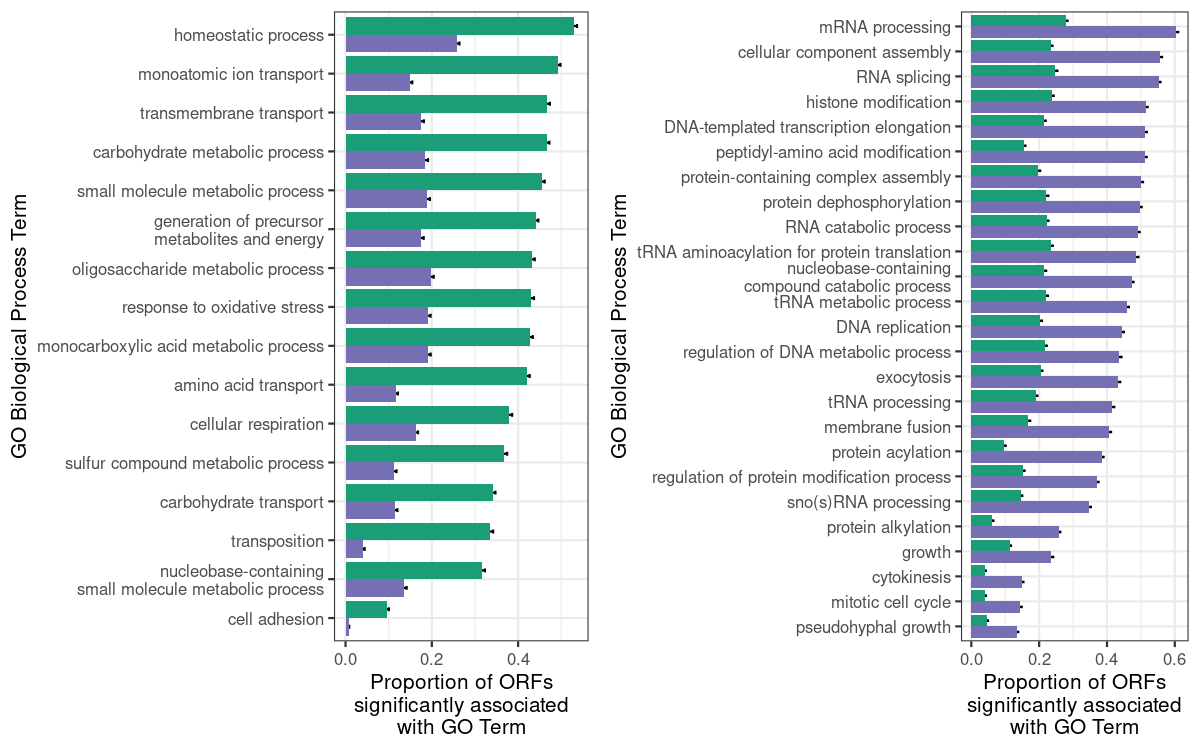

In [39]:
fig.size(8,5)

bar_plot_data = gsea_slim_counts_among_enriched%>%filter(fdr_canonical_noncanonical<0.001)%>%filter(odds >2 | odds<0.5)%>%
mutate(or = ifelse(odds>1, 'enriched','purified'),
      TERM=case_when(
          TERM == 'generation of precursor metabolites and energy' ~ 'generation of precursor\nmetabolites and energy',
          TERM == 'nucleobase-containing small molecule metabolic process' ~ 'nucleobase-containing\nsmall molecule metabolic process',
          TERM == 'nucleobase-containing compound catabolic process' ~ 'nucleobase-containing\ncompound catabolic process',
          TRUE ~ TERM
      ))%>%
mutate(se_canonical= sqrt(prop_canonical*(1-prop_canonical)/(n.x_canonical+diff_noncanonical)),
      se_noncanonical= sqrt(prop_noncanonical*(1-prop_noncanonical)/(n.x_noncanonical+diff_noncanonical)))%>%
pivot_longer(c(prop_canonical,prop_noncanonical), names_to=c('prop','class1'),names_sep='_',values_to = 'prop_value')%>%
pivot_longer(c(se_canonical,se_noncanonical), names_to = c('se','class2'),names_sep='_', values_to = 'se_value')%>%
filter(class1==class2)#%>%
#pivot_longer(cols=prop_conserved:prop_denovo, names_to='classification', values_to='prop')%>%separate(classification, c(NA,'classification'))


p1<-bar_plot_data%>%filter(odds>2)%>%#head(30)%>%
mutate(TERM = factor(TERM, levels = bar_plot_data%>%filter(class1=='noncanonical')%>%
                     ungroup()%>%arrange(prop_value)%>%dplyr::select(TERM)%>%pull()))%>%
ggplot(aes(x=prop_value,y=TERM,fill=class1))+
geom_errorbar(aes(xmin=prop_value-se_value, xmax=prop_value+se_value), width=.2,
                 position=position_dodge(.9))+
geom_bar(stat="identity", position=position_dodge(width=.9))+
theme_bw()+xlab("Proportion of ORFs\nsignificantly associated\nwith GO Term")+ylab("GO Biological Process Term")+
theme(legend.position='none', legend.title=element_blank(), axis.text = element_text(size=8), axis.title = element_text(size=10))+
scale_fill_manual(values=c('#7570b3','#1b9e77'))


p2<-bar_plot_data%>%filter(odds<.5)%>%#head(30)%>%
mutate(TERM = factor(TERM, levels = bar_plot_data%>%filter(class1=='canonical')%>%
                     ungroup()%>%arrange(prop_value)%>%dplyr::select(TERM)%>%pull()))%>%
ggplot(aes(x=prop_value,y=TERM,fill=class1))+
geom_errorbar(aes(xmin=prop_value-se_value, xmax=prop_value+se_value), width=.2,
                 position=position_dodge(.9))+
geom_bar(stat="identity", position=position_dodge(width=.9))+
theme_bw()+xlab("Proportion of ORFs\nsignificantly associated\nwith GO Term")+ylab("GO Biological Process Term")+
theme(legend.position='none', legend.title=element_blank(), axis.text = element_text(size=8), axis.title = element_text(size=10))+
scale_fill_manual(values=c('#7570b3','#1b9e77'))
#facet_grid(cols=vars(or))+geom_text(aes(label=ifelse(class1=='denovo',paste0("OR:",sprintf("%.2f",odds)),""),x=.85))+xlim(0,1)
#
cowplot::plot_grid(p1,p2)
ggsave('../reports/figures/paper_figures_01062023/gsea_canon_noncanon_enr_pur.pdf', width=8, height=5)


In [24]:
gsea_slim_kegg <- data.table::fread('../data/interim/fgsea_kegg_noexponent.csv')

In [25]:
orfs_with_gsea_kegg <-coexpression_orf_list%>%filter(transcript%in%expression$transcript)%>%#mutate(is_canonical=orf_class=='Verified'|orf_class=='Uncharacterized')%>%
inner_join(gsea_slim_kegg%>%filter(pathway!=''), by=c('transcript'))

In [31]:
kegg_slim_counts_among_enriched <-coexpression_orf_list%>%inner_join(gsea_slim_kegg, by=c('transcript'))%>%
    group_by(pathway,to,is_canonical)%>%count()%>%
inner_join(coexpression_orf_list%>%filter(transcript%in%gsea_slim_kegg$transcript)%>%group_by(is_canonical)%>%count(), by=c('is_canonical'))%>%
mutate(prop = n.x/n.y, diff = n.y-n.x)%>%
#filter(classification!='intergenic' & classification!='other')%>%
arrange(desc(prop))%>%pivot_wider(id_cols = c('pathway','to'),names_from='is_canonical',values_from=c("n.x","diff",'prop'))%>%drop_na()%>%
    mutate(p_canonical_noncanonical = fisher.test(matrix(c(n.x_noncanonical,diff_noncanonical,n.x_canonical,diff_noncanonical),nrow=2))$p.value
          )%>%
mutate(odds = prop_noncanonical/prop_canonical)%>%arrange(desc(odds))

kegg_slim_counts_among_enriched$fdr_canonical_noncanonical = p.adjust(kegg_slim_counts_among_enriched$p_canonical_noncanonical, method='fdr')



In [33]:
kegg_slim_counts_among_enriched$TERM <- str_split( kegg_slim_counts_among_enriched$to,' - ',simplify = T)[,1]

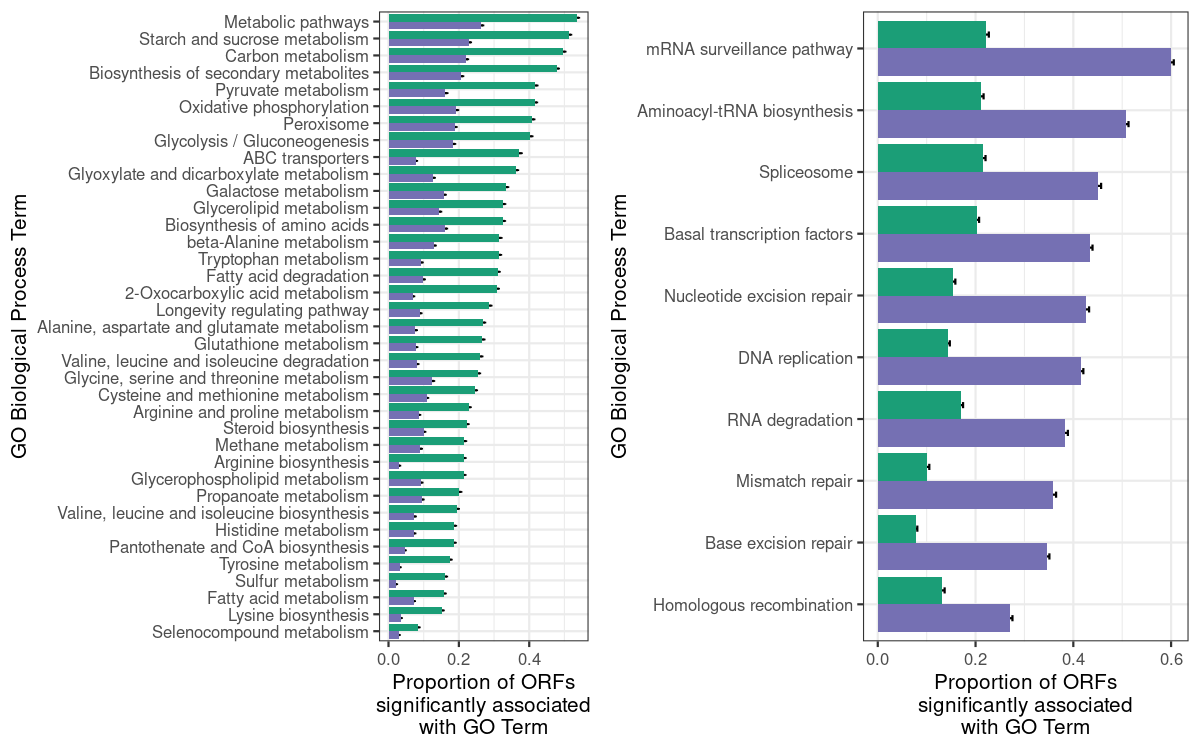

In [37]:
fig.size(8,5)

bar_plot_data = kegg_slim_counts_among_enriched%>%filter(fdr_canonical_noncanonical<0.001)%>%filter(odds >2 | odds<0.5)%>%
mutate(or = ifelse(odds>1, 'enriched','purified'),
      TERM=case_when(
          TERM == 'generation of precursor metabolites and energy' ~ 'generation of precursor\nmetabolites and energy',
          TERM == 'nucleobase-containing small molecule metabolic process' ~ 'nucleobase-containing\nsmall molecule metabolic process',
          TERM == 'nucleobase-containing compound catabolic process' ~ 'nucleobase-containing\ncompound catabolic process',
          TRUE ~ TERM
      ))%>%
mutate(se_canonical= sqrt(prop_canonical*(1-prop_canonical)/(n.x_canonical+diff_noncanonical)),
      se_noncanonical= sqrt(prop_noncanonical*(1-prop_noncanonical)/(n.x_noncanonical+diff_noncanonical)))%>%
pivot_longer(c(prop_canonical,prop_noncanonical), names_to=c('prop','class1'),names_sep='_',values_to = 'prop_value')%>%
pivot_longer(c(se_canonical,se_noncanonical), names_to = c('se','class2'),names_sep='_', values_to = 'se_value')%>%
filter(class1==class2)#%>%
#pivot_longer(cols=prop_conserved:prop_denovo, names_to='classification', values_to='prop')%>%separate(classification, c(NA,'classification'))


p1<-bar_plot_data%>%filter(odds>2)%>%#head(30)%>%
mutate(TERM = factor(TERM, levels = bar_plot_data%>%filter(class1=='noncanonical')%>%
                     ungroup()%>%arrange(prop_value)%>%dplyr::select(TERM)%>%pull()))%>%
ggplot(aes(x=prop_value,y=TERM,fill=class1))+
geom_errorbar(aes(xmin=prop_value-se_value, xmax=prop_value+se_value), width=.2,
                 position=position_dodge(.9))+
geom_bar(stat="identity", position=position_dodge(width=.9))+
theme_bw()+xlab("Proportion of ORFs\nsignificantly associated\nwith GO Term")+ylab("GO Biological Process Term")+
theme(legend.position='none', legend.title=element_blank(), axis.text = element_text(size=8), axis.title = element_text(size=10))+
scale_fill_manual(values=c('#7570b3','#1b9e77'))


p2<-bar_plot_data%>%filter(odds<.5)%>%#head(30)%>%
mutate(TERM = factor(TERM, levels = bar_plot_data%>%filter(class1=='canonical')%>%
                     ungroup()%>%arrange(prop_value)%>%dplyr::select(TERM)%>%pull()))%>%
ggplot(aes(x=prop_value,y=TERM,fill=class1))+
geom_errorbar(aes(xmin=prop_value-se_value, xmax=prop_value+se_value), width=.2,
                 position=position_dodge(.9))+
geom_bar(stat="identity", position=position_dodge(width=.9))+
theme_bw()+xlab("Proportion of ORFs\nsignificantly associated\nwith GO Term")+ylab("GO Biological Process Term")+
theme(legend.position='none', legend.title=element_blank(), axis.text = element_text(size=8), axis.title = element_text(size=10))+
scale_fill_manual(values=c('#7570b3','#1b9e77'))
#facet_grid(cols=vars(or))+geom_text(aes(label=ifelse(class1=='denovo',paste0("OR:",sprintf("%.2f",odds)),""),x=.85))+xlim(0,1)
#
cowplot::plot_grid(p1,p2)
ggsave('../reports/figures/paper_figures_01062023/gsea_kegg_canon_noncanon_enr_pur.pdf', width=8, height=5)
